In [42]:
# FIRST STEP
# interact with the operating system 
import os
from pathlib import Path
import git
import glob
import csv
# data structuration and calculations
import pandas as pd  # to create data frames
import numpy as np   # most important numerical calculations
from scipy.stats import pearsonr
import pingouin as pg
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
# needed to extract the run number out of the parentesis of the string in the SPM.mat file
import re
# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
################################################
# VARIABLES FOR PATH SELECTION AND DATA ACCESS #
################################################
HOME            = str(Path.home())
# DATA
STIM_DIR = os.path.join(HOME,'Documents/Magic_fMRI/Stimuli')
PROJ_DIR        = os.path.join(HOME, 'Documents/Magic_fMRI/DATA/MRI')
RAW_DIR         = os.path.join(PROJ_DIR, 'rawdata')
DERIVATIVES_DIR = os.path.join(PROJ_DIR, 'derivatives')
DATA_DIR = os.path.join(DERIVATIVES_DIR, 'univariate-ROI', 'SpecialMoment', 'MagicEffects')

In [10]:
ROIS = [
        'V1', 'V2', 'V3', 'hV4', 
        'V3A', 'V3B', 
        'LO', 'VO', 
        'FEF', 'IPS',
        'ACC', 'PCC', 
        'IFG', 'aINSULA', 
        'IFJ', 'PHT', 'PF'
      ]
NETWORKS = ['DMN', 'DAN', 'VAN', 'visual']
EFFECTS = ['Appear', 'Change', 'Vanish']
PRE_POST = ['pre', 'post']

In [43]:
# plotting parameter
# font settings - recommendation from here: https://towardsdatascience.com/making-publication-quality-figures-in-python-part-i-fig-and-axes-d86c3903ad9b
mpl.rcParams['pdf.fonttype']=42
mpl.rcParams['ps.fonttype']=42
mpl.rcParams['font.family']='Arial'

# width and hight is given in inch 
# -> APA says a one column figure should be 2-3.25 inches and a two column figure should be 4.25-6.875 inches
one_col_width = 3.25
two_col_width = 6.875
# linewidth and markersize
linewidth = 2
markersize = 5
# fontsizes -> must be 8-14
titlefont = 14
labelfont = 12
legend_titlefont = 10
legendfont = 8
tickfont = 8

In [30]:
pre_post_maineffect = pd.read_csv(os.path.join(DATA_DIR,'pre_post_maineffect.csv'))
pre_post_maineffect.to_excel('univar_roi_prepost.xlsx')

In [23]:
effect_maineffect = pd.read_csv(os.path.join(DATA_DIR,'effect_maineffect.csv'))
effect_maineffect.to_excel('univar_roi_mageffect.xlsx')

In [34]:
interaction_effect = pd.read_csv(os.path.join(DATA_DIR,'interaction.csv'))
interaction_effect.to_excel('univar_roi_interaction.xlsx')

In [39]:
eff_posthoc = glob.glob(os.path.join(DATA_DIR,'*effect_post_hoc.csv'))
eff_posthoc.sort()
for eff in eff_posthoc:
    print('Inspecting {}'.format(os.path.basename(eff)))
    res = pd.read_csv(eff)
    #print(res)
    res.to_excel(os.path.basename(eff)[:-4]+'.xlsx')

Inspecting LO_effect_post_hoc.csv
Inspecting V1_effect_post_hoc.csv
Inspecting V2_effect_post_hoc.csv
Inspecting V3_effect_post_hoc.csv
Inspecting VAN_effect_post_hoc.csv
Inspecting VO_effect_post_hoc.csv
Inspecting aINSULA_effect_post_hoc.csv
Inspecting hV4_effect_post_hoc.csv


In [40]:
param_interactions = glob.glob(os.path.join(DATA_DIR,'*interaction_post_hoc.csv'))
for interaction in param_interactions:
    print('Inspecting {}'.format(os.path.basename(interaction)))
    res = pd.read_csv(interaction)
    #print(res)
    res.to_excel(os.path.basename(interaction)[:-4]+'.xlsx')

Inspecting PCC_interaction_post_hoc.csv
Inspecting IFG_interaction_post_hoc.csv


In [41]:
non_param_interactions = glob.glob(os.path.join(DATA_DIR,'*wilcox_interaction.csv'))
for interaction in non_param_interactions:
    print('Inspecting {}'.format(os.path.basename(interaction)))
    res = pd.read_csv(interaction)
    #print(res)
    res.to_excel(os.path.basename(interaction)[:-4]+'.xlsx')

Inspecting V3A_wilcox_interaction.csv
Inspecting IFJ_wilcox_interaction.csv
Inspecting PHT_wilcox_interaction.csv
Inspecting DMN_wilcox_interaction.csv
Inspecting IPS_wilcox_interaction.csv
Inspecting PF_wilcox_interaction.csv
Inspecting visual_wilcox_interaction.csv
Inspecting V3B_wilcox_interaction.csv
Inspecting DAN_wilcox_interaction.csv


In [15]:
# multidimensional scaling of univariate ROI results
# the dimensions are effect x pre-post (=6 dimensions)

#------------------------------------------------------------#
# read in data frame containing ROI values for each subject and condition
data_frame = pd.read_csv(os.path.join(DATA_DIR,'prepared_dataframe.csv'))

avg_dict = {}
for roi in ROIS:
    avg_dict[roi]=[]
    for eff in EFFECTS:
        for pp in PRE_POST:
            x = data_frame[roi][(data_frame.pre_post==pp)&(data_frame.Effect==eff)].mean()
            avg_dict[roi].append(x)
            
avg_df = pd.DataFrame(data=avg_dict,columns=avg_dict.keys())

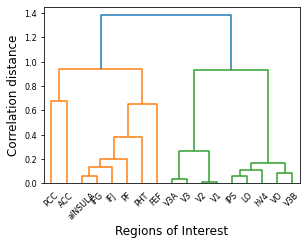

In [54]:
linked = linkage(y=avg_df.T, method='average', metric='correlation')
labelList = ROIS

fig = plt.figure(figsize=(two_col_width*2/3, one_col_width))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.xlabel('Regions of Interest',fontsize=labelfont)
plt.ylabel('Correlation distance',fontsize=labelfont)
plt.xticks(rotation=45, fontsize=tickfont)
plt.yticks(fontsize=tickfont)
fig.savefig('dendrogram.eps',format = 'eps',bbox_inches='tight')

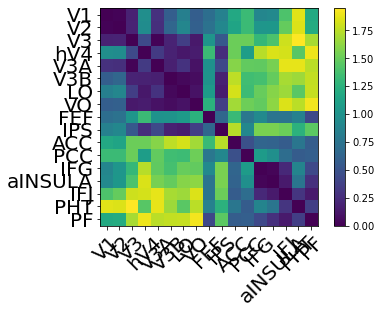

In [6]:
corr_dists = []
for name1, values1 in avg_df.iteritems():
    for name2, values2 in avg_df.iteritems():
        corr_dists.append(pearsonr(values1,values2)[0])
        
corr_dist_matrix = 1-np.array(corr_dists).reshape(len(ROIS),len(ROIS))

fig = plt.figure()
plt.imshow(corr_dist_matrix)
plt.colorbar()
plt.xticks(range(len(ROIS)),ROIS, fontsize=20, rotation=45)
plt.yticks(range(len(ROIS)),ROIS, fontsize=20);